In [1]:
import glob
import os
import torch
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import simpy as sp
import logging
import tqdm
from itertools import product
import multiprocessing as mp
from multiprocessing import Pool
from typing import Any, Iterable
from datetime import datetime as dt, timedelta as td
import joblib

In [2]:
import cdsapi

In [3]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
os.chdir('..')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from common import era5_variables as variables

In [7]:
from datasets.retrieval import grab_df_from_era5_csvs
from datasets.km_dataset import DeepKoopmanDataset
from algos.km_classical import ClassicalKoopmanAnalysis
from algos.km_havoc import HAVOCAnalysis
from algos.km_net import DeepKoopmanWrapper

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [9]:
import matplotlib.pyplot as plt

In [10]:
NCPU = mp.cpu_count() - 1

# EDA Koopman Forecast of Maritime Weather

## ERA5 Around Hamburg Harbor

ERA5 is a dataset which provides hourly maritime weather data.<br>
Its API does only provide single point measurements, but we can play a little and grab this data for multiple points all together.

![Map with coordinated of HH harbor with midpoint of the grid.](../img/map_grid_hhh.png)<br>
*Coastal map. The blue point is at coordinates lon 10 and lat 53.5, around Hamburg Harbor.*<br>
*The red dot is representing the initial radius taken when data mining the region of interest.*<br>
*One can see that that the mean on that point needs to be far more at the caostal line to get sufficiant forecasting!*

![Map with the grid of sampled datapoints.](../img/map_grid_hhh_2.png)<br>
*Coastal map with maritime weather datapoint (ERA5) for coastal line related to HH Habor.* <br>
*The blue points are complete and red ones have missing data. Only the blue ones will be considered.*<br>

In [11]:
# params
data_path = './data'
center_lon, center_lat = 5.5, 56.5
radius = 4.5
step = 0.5
start_date = '2025-02-01'
end_date = '2025-09-30'

output_dir = os.path.join(data_path, f"{start_date}--{end_date}")
lon_vals = np.arange(center_lon - radius, center_lon + radius + step, step)
lat_vals = np.arange(center_lat - radius, center_lat + radius + step, step)

In [12]:
df = grab_df_from_era5_csvs(output_dir, lat_vals, lon_vals)
df

,time,u100,v100,u10,v10,d2m,t2m,msl,sst,skt,sp,ssrd,strd,tp,lat,lon,mwd,mwp,swh
0,2025-02-01 00:00:00,-1.227249,4.551605,-0.971558,2.206314,276.52350,277.55730,103012.190,NaN,275.89688,102521.016,0.0,987721.60,0.000000e+00,52.0,1.0,NaN,NaN,NaN
1,2025-02-01 01:00:00,-1.344467,4.589905,-1.027405,2.290192,276.49360,277.50160,103025.500,NaN,275.48804,102534.330,0.0,1026047.44,0.000000e+00,52.0,1.0,NaN,NaN,NaN
2,2025-02-01 02:00:00,-1.250153,4.995331,-0.835266,2.517288,276.37183,277.37183,103046.810,NaN,275.55533,102554.920,0.0,1021265.70,0.000000e+00,52.0,1.0,NaN,NaN,NaN
3,2025-02-01 03:00:00,-1.073959,5.168274,-0.689453,2.575562,275.93164,276.87340,103048.560,NaN,275.18945,102556.310,0.0,958170.00,4.768372e-07,52.0,1.0,NaN,NaN,NaN
4,2025-02-01 04:00:00,-0.700256,5.065414,-0.453903,2.541901,275.88983,276.80780,103031.750,NaN,275.37950,102539.140,0.0,979850.20,0.000000e+00,52.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096683,2025-09-30 19:00:00,-1.078003,3.887268,-0.837814,1.905701,277.56770,278.32910,103420.125,NaN,278.16960,95322.080,0.0,1168652.20,3.099441e-05,61.0,10.0,NaN,NaN,NaN
2096684,2025-09-30 20:00:00,-0.953369,3.793167,-0.762024,1.887436,277.37200,277.93220,103431.625,NaN,278.13623,95328.805,0.0,1155937.60,2.861023e-05,61.0,10.0,NaN,NaN,NaN
2096685,2025-09-30 21:00:00,-0.952301,3.694656,-0.779129,1.820908,277.21252,277.76376,103446.375,NaN,277.84314,95336.560,0.0,1173570.80,3.004074e-05,61.0,10.0,NaN,NaN,NaN
2096686,2025-09-30 22:00:00,-0.584839,2.949158,-0.589203,1.509872,277.02023,277.70374,103458.060,NaN,277.23773,95322.200,0.0,1146051.50,3.337860e-05,61.0,10.0,NaN,NaN,NaN


In [13]:
df = df.dropna(subset=[
    'sp',
    'ssrd',
    'strd',
    'tp',
    'mwd',
    'mwp',
    'swh'
])

In [14]:
df.shape

(1422960, 19)

In [15]:
# prefilter lat, lon and time
lat_max, lat_min = df['lat'].max(), df['lat'].min()
lon_max, lon_min = df['lon'].max(), df['lon'].min()
df['time'] = pd.to_datetime(df['time'])
time_max, time_min = df['time'].max(), df['time'].min()

filt_lat = np.arange(lat_min, lat_max, step)[::3].tolist()
filt_lon = np.arange(lon_min, lon_max, step)[::3].tolist()

filt_time = (df['time'].dt.date > (dt.date(time_max - td(days=24)))).values
sprt_time = pd.to_datetime(pd.Series(pd.date_range(time_min, time_max, periods=24))).astype(int).values
sprt_date = pd.to_datetime(pd.Series(pd.date_range(time_min, time_max, periods=24))).dt.date.unique()

C:\Users\szaif\AppData\Local\Temp\ipykernel_17288\293329128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


In [16]:
idx_lat = df['lat'].apply(lambda x: x in filt_lat).values
idx_lon = df['lon'].apply(lambda x: x in filt_lon).values
idx_sptm = pd.to_datetime(df['time'].dt.date).astype(int).apply(lambda x: x in sprt_time).values
idx_time = filt_time

In [17]:
print(sum(idx_lat & idx_lon))
print(sum(idx_sptm & idx_lat & idx_lon))
print(sum(idx_time & idx_lat & idx_lon))

168432
696
16704


In [18]:
df_sprt = df.copy()
df_sprt = df_sprt[idx_sptm & idx_lat & idx_lon]

df_filt = df.copy()
df_filt = df_filt[idx_time & idx_lat & idx_lon]

In [19]:
df['date'] = df['time'].dt.date
df_sprt['date'] = df_sprt['time'].dt.date
df_filt['date'] = df_filt['time'].dt.date

C:\Users\szaif\AppData\Local\Temp\ipykernel_17288\4121194061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['time'].dt.date


In [20]:
df_sprt

,time,u100,v100,u10,v10,d2m,t2m,msl,sst,skt,sp,ssrd,strd,tp,lat,lon,mwd,mwp,swh,date
17424,2025-02-01 00:00:00,-0.057327,5.897308,-0.343628,4.855728,278.41022,279.51434,102954.690,279.51782,279.70157,102953.016,0.0,1194217.60,0.000020,53.5,1.0,354.31550,6.610472,0.778627,2025-02-01
17425,2025-02-01 01:00:00,0.351822,6.226623,0.056580,5.187653,278.23187,279.42932,102956.000,279.51782,279.68335,102955.330,0.0,1182527.50,0.000021,53.5,1.0,354.74470,6.420084,0.772938,2025-02-01
17426,2025-02-01 02:00:00,0.977387,6.259979,0.670593,5.294632,278.05933,279.31520,102982.060,279.51782,279.69986,102980.920,0.0,1136913.80,0.000027,53.5,1.0,354.81433,6.235035,0.769620,2025-02-01
17427,2025-02-01 03:00:00,1.181900,6.068665,0.886719,5.216187,277.91992,279.20154,102983.310,279.51782,279.69922,102982.310,0.0,1137722.00,0.000015,53.5,1.0,355.33190,6.135874,0.758468,2025-02-01
17428,2025-02-01 04:00:00,1.322205,5.942368,1.015823,5.196198,277.80975,279.09100,102974.500,279.51782,279.69003,102973.140,0.0,1143082.20,0.000012,53.5,1.0,355.76013,6.044157,0.747329,2025-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724995,2025-02-01 19:00:00,-1.769836,-0.111984,-1.722992,-0.388947,273.68230,276.68713,102965.375,278.50415,278.27832,102976.516,0.0,1073788.90,0.000003,58.0,8.5,270.53430,4.511496,0.363034,2025-02-01
1724996,2025-02-01 20:00:00,-0.715958,-0.211639,-0.734039,-0.508316,273.69140,276.71630,102939.875,278.50415,278.13630,102950.840,0.0,970442.94,0.000001,58.0,8.5,263.49835,4.527698,0.349084,2025-02-01
1724997,2025-02-01 21:00:00,0.121078,-0.493027,0.020920,-1.009049,273.69006,276.66820,102892.750,278.50415,278.18948,102903.270,0.0,969464.30,0.000002,58.0,8.5,257.29703,4.527389,0.338127,2025-02-01
1724998,2025-02-01 22:00:00,0.962509,-1.251816,0.521133,-1.836746,274.23816,276.77990,102832.810,278.56348,278.18787,102842.970,0.0,930045.75,0.000002,58.0,8.5,251.89894,4.719585,0.314688,2025-02-01


## Temporal Decompositions

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from skopt import gp_minimize
from skopt.space import Integer
from skopt.plots import plot_convergence

In [22]:
variables

{'t2m': '2m Temperature',
 'msl': 'Mean Sea Level',
 'skt': 'Skin Temperature',
 'sp': 'Surface Pressure',
 'ssrd': 'Surface Solar Radiation Downwards',
 'tp': 'Total Precipitation'}

#### loop over all spread dates and coordinates

In [23]:
def grab_coord_day_datapoint(
    datepoint: Any = sprt_date[np.random.choice(np.arange(len(sprt_date)))],
    latpoint: float = lat_vals[len(lat_vals)//2],
    lonpoint: float = lon_vals[len(lon_vals)//2],
    datedelta: int = 7
) -> (pd.DataFrame|None):
    dateindex = df['time'].dt.date == datepoint
    logging.debug(f". {datepoint}: {sum(dateindex)}")
    for _ in range(1, datedelta):
        datepoint = datepoint + td(days=1)
        dateindex |= df['time'].dt.date == datepoint
        logging.debug(f"+ {datepoint}: {sum(dateindex)}")
    coordindex = df['lat'] == latpoint
    coordindex &= df['lon'] == lonpoint
    if sum(dateindex & coordindex) > 0:
        return df.loc[dateindex & coordindex, ['time', 'date', 'lat', 'lon'] + list(variables.keys())].copy()
    else:
        logging.warning(f'Empty dataframe for date {datepoint}, lat {latpoint}, lon {lonpoint}')
        return None

In [24]:
grab_coord_day_datapoint()

,time,date,lat,lon,t2m,msl,skt,sp,ssrd,tp
1050480,2025-08-30 00:00:00,2025-08-30,56.5,5.5,290.11578,99908.500,289.54980,99903.805,0.0,2.627373e-04
1050481,2025-08-30 01:00:00,2025-08-30,56.5,5.5,290.27484,99892.440,289.55188,99888.375,0.0,1.573563e-04
1050482,2025-08-30 02:00:00,2025-08-30,56.5,5.5,290.19556,99873.250,289.56805,99869.300,0.0,3.504753e-04
1050483,2025-08-30 03:00:00,2025-08-30,56.5,5.5,289.98193,99841.690,289.57184,99837.530,0.0,1.945496e-04
1050484,2025-08-30 04:00:00,2025-08-30,56.5,5.5,289.91740,99823.000,289.56403,99818.234,0.0,8.964539e-05
...,...,...,...,...,...,...,...,...,...,...
1050643,2025-09-05 19:00:00,2025-09-05,56.5,5.5,289.27908,101945.810,289.74658,101940.890,7552.0,4.768372e-07
1050644,2025-09-05 20:00:00,2025-09-05,56.5,5.5,289.13928,101978.750,289.73490,101974.086,0.0,0.000000e+00
1050645,2025-09-05 21:00:00,2025-09-05,56.5,5.5,288.97485,102046.375,289.73180,102041.320,0.0,4.768372e-07
1050646,2025-09-05 22:00:00,2025-09-05,56.5,5.5,289.01500,102096.440,289.73627,102092.030,0.0,9.536743e-07


In [25]:
filt_coord = list(set(
    zip(df['lat'].tolist(), df['lon'].tolist())
).intersection(
    zip(filt_lat, filt_lon)
))
(filt_lat, filt_lon) = zip(*filt_coord)
filt_coord, filt_lat, filt_lon

([(58.0, 7.0), (56.5, 5.5), (55.0, 4.0), (53.5, 2.5)],
 (58.0, 56.5, 55.0, 53.5),
 (7.0, 5.5, 4.0, 2.5))

In [26]:
df_filt.shape

(16704, 20)

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(11)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(9)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(16)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(18)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at 

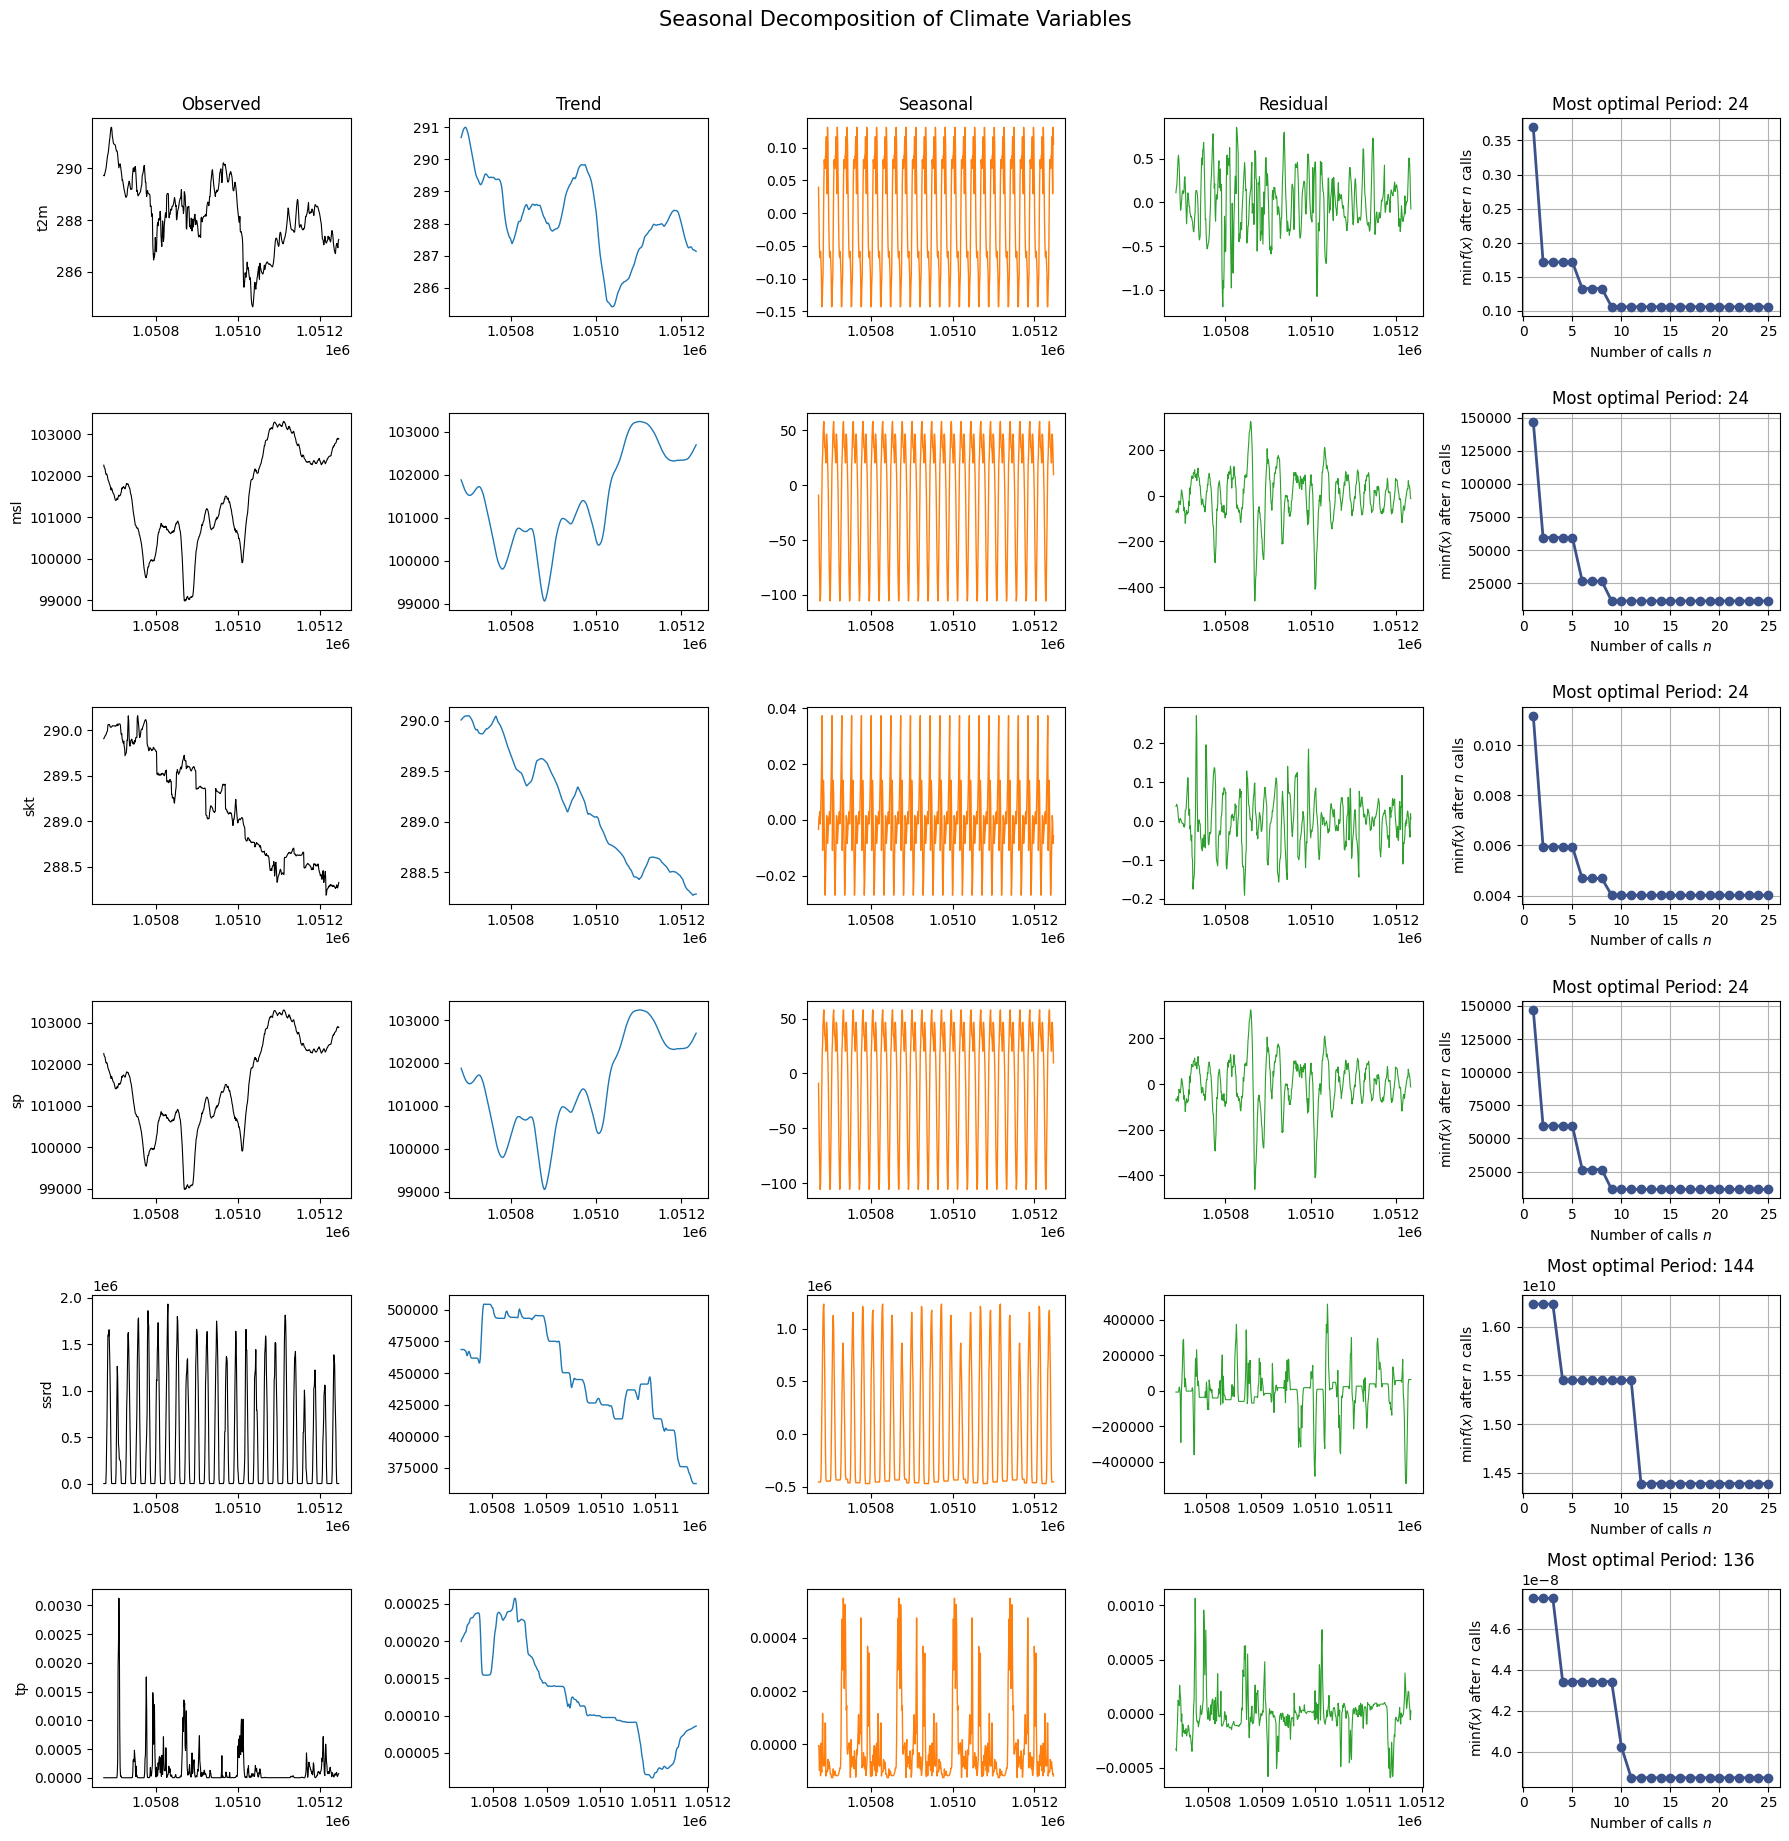

In [27]:
# Prepare a grid of subplots (rows per variable)
n_vars = len(variables)
# Define search space — e.g., range of candidate periods (hourly → 6h to 120 days)
periods = [Integer(3, 18, name="period")]
p_mul = 8

lat_val = lat_vals[len(lat_vals)//2]
lon_val = lon_vals[len(lon_vals)//2]

coord_filt = (df_filt['lat'] == lat_val) & (df_filt['lon'] == lon_val)

# main plot frame
fig, axes = plt.subplots(
    nrows=n_vars, ncols=5, figsize=(18, 3 * n_vars)
)
column_titles = ["Observed", "Trend", "Seasonal", "Residual", "Period Convergence"]
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=12)

# Loop and plot results for each variable
for i, var in enumerate(variables):
    series = df_filt.loc[coord_filt, var].dropna()

    # Define objective function to minimize residual error
    def objective(period) -> (Any | float):
        period = p_mul*period[0]
        try:
            result = seasonal_decompose(series, model="additive", period=int(period))
            resid = result.resid.dropna()
            # compute sum of squared residual
            score = np.mean(resid.values ** 2)
        except Exception:
            score = np.inf  # invalid period or failed decomposition
        return score

    # Run Bayesian optimization
    res = gp_minimize(
        objective,
        dimensions=periods,
        n_calls=25,
        n_random_starts=8,
        random_state=42,
    )

    # parse "optimal" period
    period = res.x[0] * p_mul  # type: ignore
    
    # get final decomposition
    result = seasonal_decompose(series, model="additive", period=period)

    axes[i, 0].plot(result.observed, color="black", lw=0.8)
    axes[i, 0].set_ylabel(var)
    axes[i, 1].plot(result.trend, color="tab:blue", lw=1.0)
    axes[i, 2].plot(result.seasonal, color="tab:orange", lw=1.0)
    axes[i, 3].plot(result.resid, color="tab:green", lw=0.8)
    plot_convergence(res, ax=axes[i, 4])
    axes[i, 4].set_title(f"Most optimal Period: {period}")

plt.suptitle("Seasonal Decomposition of Climate Variables", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

#### Save and grab all optimal decompositions

In [28]:
from utils.tsa_features import opt_decomp

In [29]:
try:
    decomps = joblib.load('./models/hhh_maritime/tsa/decomps.pkl')
except FileNotFoundError:
    # using 7 days each to have enough cycles
    decomps = []
    for args in tqdm.tqdm(product(sprt_date, filt_lat, filt_lon)):
        datapoint = grab_coord_day_datapoint(*args)
        if datapoint is not None:
            decomps += [opt_decomp(datapoint)]
    joblib.dump(decomps, './models/hhh_maritime/tsa/decomps.pkl')

In [30]:
len(decomps)

368

In [31]:
decomps[0][0]

,time,date,lat,lon,t2m,msl,skt,sp,ssrd,tp,...,sp_season,sp_trend,sp_resid,ssrd_season,ssrd_trend,ssrd_resid,tp_season,tp_trend,tp_resid,decomp_cluster
1393920,2025-02-01 00:00:00,2025-02-01,58.0,7.0,275.32490,102814.440,278.39883,102212.016,0.0,0.000000,...,5.993385,NaN,NaN,-111899.287037,NaN,NaN,-0.000027,NaN,NaN,1
1393921,2025-02-01 01:00:00,2025-02-01,58.0,7.0,274.94300,102879.750,278.37085,102275.330,0.0,0.000000,...,4.173492,NaN,NaN,-114344.842593,NaN,NaN,-0.000008,NaN,NaN,1
1393922,2025-02-01 02:00:00,2025-02-01,58.0,7.0,274.69604,102914.810,278.38345,102309.920,0.0,0.000000,...,5.652912,NaN,NaN,-116717.731481,NaN,NaN,0.000032,NaN,NaN,1
1393923,2025-02-01 03:00:00,2025-02-01,58.0,7.0,274.60388,102925.310,278.39844,102318.310,0.0,0.000000,...,-6.809553,NaN,NaN,-118747.731481,NaN,NaN,0.000020,NaN,NaN,1
1393924,2025-02-01 04:00:00,2025-02-01,58.0,7.0,274.63593,102990.500,278.43613,102383.140,0.0,0.000000,...,-10.720185,NaN,NaN,-119938.842593,NaN,NaN,0.000038,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394083,2025-02-07 19:00:00,2025-02-07,58.0,7.0,275.83197,103924.560,277.64676,103313.720,0.0,0.000001,...,4.173492,NaN,NaN,-105628.842593,NaN,NaN,-0.000035,NaN,NaN,1
1394084,2025-02-07 20:00:00,2025-02-07,58.0,7.0,275.83570,103895.750,277.65146,103284.890,0.0,0.000005,...,5.652912,NaN,NaN,-105703.731481,NaN,NaN,-0.000070,NaN,NaN,1
1394085,2025-02-07 21:00:00,2025-02-07,58.0,7.0,275.87918,103874.310,277.68762,103263.680,0.0,0.000042,...,-6.809553,NaN,NaN,-106266.398148,NaN,NaN,-0.000069,NaN,NaN,1
1394086,2025-02-07 22:00:00,2025-02-07,58.0,7.0,275.71616,103790.560,277.69180,103180.760,0.0,0.000127,...,-10.720185,NaN,NaN,-107595.064815,NaN,NaN,-0.000045,NaN,NaN,1


In [32]:
variables['tp']

'Total Precipitation'

([<matplotlib.lines.Line2D at 0x195c4de8a90>],
 dict_keys(['time', 'lon', 'lat', 'decomp', 'period']))

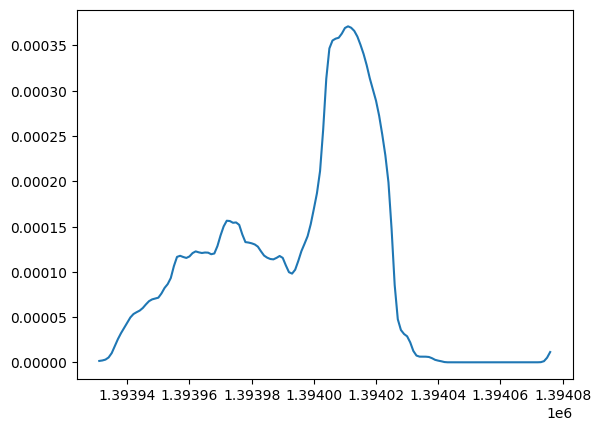

In [33]:
plt.plot(decomps[0][0]['tp_trend']), decomps[0][1][0].keys()

In [34]:
f'{decomps[0][1][0]["time"][0]} - {decomps[0][1][0]["time"][-1]}', len(decomps[0][0]['tp_trend']) / 24

('2025-02-01 00:00:00 - 2025-02-07 23:00:00', 7.0)

In [35]:
decomp_var_trends = []
decomp_var_seasons = []
decomp_var_resids = []
for var in variables.keys():
    decomp_var_trends += [f'{var}_trend']
    decomp_var_seasons += [f'{var}_season']
    decomp_var_resids += [f'{var}_resid']

for decomp in decomps:
    print('-'*21)
    for varset in [decomp_var_trends, decomp_var_seasons, decomp_var_resids]:
        all_nans = pd.concat(list(map(
            lambda v: pd.Series(
                decomp[0][v].isna().sum(),
                name=v
            ),
            varset
        )), axis=1)
        print(f'{all_nans}')

---------------------
   t2m_trend  msl_trend  skt_trend  sp_trend  ssrd_trend  tp_trend
0         20         18         18        18          24        22
   t2m_season  msl_season  skt_season  sp_season  ssrd_season  tp_season
0           0           0           0          0            0          0
   t2m_resid  msl_resid  skt_resid  sp_resid  ssrd_resid  tp_resid
0         20         18         18        18          24        22
---------------------
   t2m_trend  msl_trend  skt_trend  sp_trend  ssrd_trend  tp_trend
0         18         18         18        18          24        18
   t2m_season  msl_season  skt_season  sp_season  ssrd_season  tp_season
0           0           0           0          0            0          0
   t2m_resid  msl_resid  skt_resid  sp_resid  ssrd_resid  tp_resid
0         18         18         18        18          24        18
---------------------
   t2m_trend  msl_trend  skt_trend  sp_trend  ssrd_trend  tp_trend
0         20         18         18     

### Clustering the Decompositions

In [36]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

In [37]:
X_trend_mm = np.stack(list(map(
    lambda d: d[0][decomp_var_trends].values,
    decomps
)))
X_season_mm = np.stack(list(map(
    lambda d: d[0][decomp_var_seasons].values,
    decomps
)))
X_resid_mm = np.stack(list(map(
    lambda d: d[0][decomp_var_resids].values,
    decomps
)))

X_trend_mm.shape, X_season_mm.shape, X_resid_mm.shape

((368, 168, 6), (368, 168, 6), (368, 168, 6))

In [38]:
inp_sprt_decomp = KNNImputer(n_neighbors=24)
X_interp_mm = inp_sprt_decomp.fit_transform(np.concat([
    X_trend_mm, X_season_mm, X_resid_mm
], axis=2).transpose(0,2,1).reshape(-1, 168)).reshape(368, -1, 168).transpose(0, 2, 1)

In [39]:
X_trend_imp = X_interp_mm[:, :, :6]
X_season_imp = X_interp_mm[:, :, 6:12]
X_resid_imp = X_interp_mm[:, :, -6:]
X_trend_imp.shape, X_season_imp.shape, X_resid_imp.shape

((368, 168, 6), (368, 168, 6), (368, 168, 6))

In [40]:
try:
    cluster_st = joblib.load('./models/hhh_maritime/tsa/cluster_season_trend.pkl')
except FileNotFoundError:
    cluster_st = KMeans(3).fit(
        np.concat([X_trend_imp, X_season_imp], 2).reshape(368, -1)
    )
    joblib.dump(cluster_st, './models/hhh_maritime/tsa/cluster_season_trend.pkl')

cl_st = cluster_st.predict(
    np.concat([X_trend_imp, X_season_imp], 2).reshape(368, -1)
)
cl_st

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,

In [41]:
df_filt

,time,u100,v100,u10,v10,d2m,t2m,msl,sst,skt,sp,ssrd,strd,tp,lat,lon,mwd,mwp,swh,date
22656,2025-09-07 00:00:00,-9.818741,11.781036,-7.583176,8.436493,287.66483,292.02628,101447.875,289.96973,289.94885,101446.860,0.0,1194936.9,0.000000,53.5,1.0,131.092060,4.892267,1.709367,2025-09-07
22657,2025-09-07 01:00:00,-9.241959,11.989532,-7.184097,8.537750,287.59976,291.94687,101408.940,289.96973,289.94028,101407.650,0.0,1145403.5,0.000000,53.5,1.0,131.507690,4.963750,1.719125,2025-09-07
22658,2025-09-07 02:00:00,-8.642761,12.104980,-6.778000,8.616348,287.56880,291.89410,101351.690,289.96973,289.93744,101350.350,0.0,1146199.5,0.000000,53.5,1.0,132.249150,5.007956,1.715118,2025-09-07
22659,2025-09-07 03:00:00,-8.766068,12.307983,-6.893509,8.795288,287.58844,291.76904,101254.810,289.96973,289.93546,101253.670,0.0,1150483.0,0.000000,53.5,1.0,132.993400,5.038896,1.711791,2025-09-07
22660,2025-09-07 04:00:00,-8.597900,12.400330,-6.709503,8.941040,287.64160,291.64703,101204.310,289.96973,289.93604,101202.690,0.0,1155534.0,0.000000,53.5,1.0,133.570100,5.058062,1.709803,2025-09-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730779,2025-09-30 19:00:00,-6.622925,3.058167,-6.181564,2.737732,280.29230,286.02832,103233.625,287.88940,287.66763,103244.080,0.0,1169772.2,0.000082,58.0,8.5,110.611206,3.899760,0.850064,2025-09-30
1730780,2025-09-30 20:00:00,-5.559814,3.203323,-5.262024,2.827866,280.53607,286.00640,103228.875,287.88940,287.65967,103239.805,0.0,1206401.6,0.000017,58.0,8.5,113.041176,3.896558,0.816791,2025-09-30
1730781,2025-09-30 21:00:00,-4.926910,3.252274,-4.763504,2.872665,280.60510,286.10360,103251.875,287.88940,287.65370,103261.560,0.0,1177762.8,0.000013,58.0,8.5,115.253350,3.888679,0.774295,2025-09-30
1730782,2025-09-30 22:00:00,-5.710815,4.997986,-5.390961,4.460068,280.73312,286.06116,103237.810,287.66480,287.66547,103248.200,0.0,1147523.5,0.000007,58.0,8.5,118.836494,3.811084,0.779467,2025-09-30


In [42]:
from datasets.utils import add_specification

In [43]:
try:
    df_cluster = pd.read_csv('./data/hhh_maritime/tsa/df_cluster.csv', index_col=0)
    df_cluster['time'] = pd.to_datetime(df_cluster['time'])
    df_cluster['week'] = df_cluster['time'].dt.isocalendar().week
    df_cluster['date'] = df_cluster['time'].dt.date
except FileNotFoundError:
    df_cluster = pd.concat(list(map(
        lambda data_: add_specification(data_[0][0], data_[1], 'decomp_cluster'),
        zip(decomps, cl_st.tolist())
    )), axis=0)
    df_cluster.to_csv('./data/hhh_maritime/tsa/df_cluster.csv')

### Vizualization

##### Run the function below once to probably fix "mapbox" plots with PlotLy!

In [44]:
import shutil
import pkg_resources

PLOTLY_MAPBOX_FIXED = os.getenv('PLOTLY_MAPBOX_FIXED', False)

def fix_mapbox_derived_error():
    pkg_dir = os.path.dirname(pkg_resources.resource_filename("plotly", "plotly.py"))
    basedatatypesPath = os.path.join(pkg_dir, "basedatatypes.py")
    backup_file = basedatatypesPath.replace(".py", "_bk.py")
    shutil.copyfile(basedatatypesPath, backup_file)

    with open(basedatatypesPath, "r") as f:
        lines = f.read()

    find = "if not BaseFigure._is_key_path_compatible(key_path_str, self.layout):"
    replace = """if not BaseFigure._is_key_path_compatible(key_path_str, self.layout):
                if key_path_str == "mapbox._derived":
                    return"""
    lines = lines.replace(find, replace)

    with open(basedatatypesPath, "w") as f:
        f.write(lines)

if not PLOTLY_MAPBOX_FIXED:
    fix_mapbox_derived_error()


C:\Users\szaif\AppData\Local\Temp\ipykernel_17288\2485574619.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [45]:
variables

{'t2m': '2m Temperature',
 'msl': 'Mean Sea Level',
 'skt': 'Skin Temperature',
 'sp': 'Surface Pressure',
 'ssrd': 'Surface Solar Radiation Downwards',
 'tp': 'Total Precipitation'}

In [46]:
weeks_filt = list(map(
    lambda date: pd.Series(pd.date_range(date[0], date[1], 7)),
    zip(sprt_date, sprt_date + td(days=6))
))

In [47]:

df_cluster['window'] = 'N/A'
for _, date_ in tqdm.tqdm(enumerate(weeks_filt)):
    selected_week = date_.dt.date.values
    df_cluster.loc[
        df_cluster['date'].apply(lambda date: date in selected_week),
        'window'
    ] = f'{selected_week[0]}--{selected_week[-1]}'
df_cluster

24it [00:05,  4.46it/s]


,time,date,lat,lon,t2m,msl,skt,sp,ssrd,tp,...,sp_resid,ssrd_season,ssrd_trend,ssrd_resid,tp_season,tp_trend,tp_resid,decomp_cluster,week,window
1393920,2025-02-01 00:00:00,2025-02-01,58.0,7.0,275.32490,102814.440,278.39883,102212.016,0.0,0.000000,...,NaN,-111899.287037,NaN,NaN,-0.000027,NaN,NaN,1,5,2025-02-01--2025-02-07
1393921,2025-02-01 01:00:00,2025-02-01,58.0,7.0,274.94300,102879.750,278.37085,102275.330,0.0,0.000000,...,NaN,-114344.842593,NaN,NaN,-0.000008,NaN,NaN,1,5,2025-02-01--2025-02-07
1393922,2025-02-01 02:00:00,2025-02-01,58.0,7.0,274.69604,102914.810,278.38345,102309.920,0.0,0.000000,...,NaN,-116717.731481,NaN,NaN,0.000032,NaN,NaN,1,5,2025-02-01--2025-02-07
1393923,2025-02-01 03:00:00,2025-02-01,58.0,7.0,274.60388,102925.310,278.39844,102318.310,0.0,0.000000,...,NaN,-118747.731481,NaN,NaN,0.000020,NaN,NaN,1,5,2025-02-01--2025-02-07
1393924,2025-02-01 04:00:00,2025-02-01,58.0,7.0,274.63593,102990.500,278.43613,102383.140,0.0,0.000000,...,NaN,-119938.842593,NaN,NaN,0.000038,NaN,NaN,1,5,2025-02-01--2025-02-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354187,2025-09-26 19:00:00,2025-09-26,53.5,2.5,288.36212,102292.625,289.06067,102281.970,0.0,0.000052,...,NaN,-468119.703704,NaN,NaN,-0.000016,NaN,NaN,2,39,2025-09-20--2025-09-26
354188,2025-09-26 20:00:00,2025-09-26,53.5,2.5,288.56450,102290.250,289.05084,102278.670,0.0,0.000027,...,NaN,-465942.148148,NaN,NaN,-0.000030,NaN,NaN,2,39,2025-09-20--2025-09-26
354189,2025-09-26 21:00:00,2025-09-26,53.5,2.5,288.64470,102278.750,289.05646,102268.390,0.0,0.000050,...,NaN,-462067.481481,NaN,NaN,-0.000039,NaN,NaN,2,39,2025-09-20--2025-09-26
354190,2025-09-26 22:00:00,2025-09-26,53.5,2.5,288.06080,102243.000,289.03424,102232.040,0.0,0.000047,...,NaN,-459042.592593,NaN,NaN,-0.000037,NaN,NaN,2,39,2025-09-20--2025-09-26


In [117]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

# Prepare dropdown options
selected_vars = list(variables.keys())  # list of variable names
dates = weeks_filt
weeks = {
    f'{pd.Series(dates[j]).dt.isocalendar().week.values[0]}': j
    for j in range(len(dates)) 
}
coords = sorted(set(zip(df_cluster['lat'], df_cluster['lon'])))
coord_strings = [f"({lat},{lon})" for lat, lon in coords]

week_dropdown = widgets.Dropdown(options=list(weeks.keys()), value=list(weeks.keys())[0], description='Week:')
coord_dropdown = widgets.Dropdown(options=coord_strings, value=coord_strings[0], description='Coordinate:')

# Arrange dropdowns side by side
controls = widgets.HBox([week_dropdown, coord_dropdown])

# Display controls first
controls.layout.width = '1400px'
display(controls)

# Create FigureWidget for interactive plots
fig = make_subplots(
    rows=3, cols=2,
    specs=[[{"type": "mapbox"}, {"type": "xy"}],
           [{"type": "mapbox"}, {"type": "xy"}],
           [{"type": "mapbox"}, {"type": "xy"}]],
    column_widths=[0.50, 0.50],
    row_heights=[0.33, 0.33, 0.34],
    vertical_spacing=0.025,
    horizontal_spacing=.025,
)
fig = go.FigureWidget(fig)

# temprary assignment
selected_week = dates[weeks[week_dropdown.value]].dt.date.values
df_week = df_cluster[df_cluster['date'].apply(lambda date: date in selected_week)]
    
# Plot the cluster map on the left spanning rows
fig.add_trace(go.Scattermapbox(
    lat=df_week['lat'], lon=df_week['lon'],
    mode='markers',
    marker=dict(color=df_week['decomp_cluster'], size=10, colorscale='Viridis'),
    text=["Cluster: " + str(c) for c in df_week['decomp_cluster']],
    showlegend=False,
), row=1, col=1)

# Update map layout once
lat_min, lat_max = df_cluster['lat'].min(), df_cluster['lat'].max()
lon_min, lon_max = df_cluster['lon'].min(), df_cluster['lon'].max()
fig.update_layout(
    mapbox=dict(
        domain=dict(x=[0, 0.45], y=[0, 1]),
        center={"lat": (lat_min + lat_max) // 2, "lon": (lon_min + lon_max) // 2},
        zoom=5.25,
        style="carto-positron",
    )
)

def clear_traces(fig):
    fig.data = []

def update_figure(change):
    # Parse selected coordinate string to tuple
    selected_coord = tuple(map(float, coord_dropdown.value.strip('()').split(',')))
    selected_week = dates[weeks[week_dropdown.value]].dt.date.values
    df_week = df_cluster[df_cluster['date'].apply(lambda date: date in selected_week)]

    # Clear existing traces safely
    clear_traces(fig)
    
    # Plot the cluster map on the left spanning rows
    fig.add_trace(go.Scattermapbox(
        lat=df_week['lat'], lon=df_week['lon'],
        mode='markers',
        marker=dict(color=df_week['decomp_cluster'], size=10, colorscale='Viridis'),
        text=["Cluster: " + str(c) for c in df_week['decomp_cluster']],
        showlegend=False,
    ), row=1, col=1)

    point = df_week['lat'] == selected_coord[0]
    point &= df_week['lon'] == selected_coord[1]
    df_point = df_week[point]
    
    # Plot trend, seasonal, residual for right column rows
    components = ['trend', 'season', 'resid']
    for i, component in enumerate(components, start=1):
        for var in selected_vars:
            y_arr = df_point[var + '_' + component].values
            if np.sum(~np.isnan(y_arr)) < 1:
                y_arr[:] == 0
            else:
                y_arr_den = np.nanmax(np.abs(y_arr)) + 1e-8
                y_arr /= y_arr_den
            # if df_point.empty:
            #     logging.warning(f'Empty DataFrame at {selected_coord} on week {selected_week}')
            #     continue
            fig.add_trace(go.Scatter(
                y=y_arr, mode='lines',
                name=f"{component.capitalize()} {var} (den: {y_arr_den :0.2f}) {selected_coord}"
            ), row=i, col=2)
    fig.show()

# Bind dropdown changes to update function
week_dropdown.observe(update_figure, names='value')
coord_dropdown.observe(update_figure, names='value')

# Display and initial figure
fig.layout.width = 1600
fig.layout.height = 800
display(fig)
update_figure(None)


C:\Users\szaif\AppData\Local\Temp\ipykernel_17288\2000443497.py:44: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



FigureWidget({
    'data': [{'lat': {'bdata': ('AAAAAAAATUAAAAAAAABNQAAAAAAAAE' ... 'AAAADASkAAAAAAAMBKQAAAAAAAwEpA'),
                      'dtype': 'f8'},
              'lon': {'bdata': ('AAAAAAAAHEAAAAAAAAAcQAAAAAAAAB' ... 'AAAAAABEAAAAAAAAAEQAAAAAAAAARA'),
                      'dtype': 'f8'},
              'marker': {'color': {'bdata': ('AQEBAQEBAQEBAQEBAQEBAQEBAQEBAQ' ... 'EBAQEBAQEBAQEBAQEBAQEBAQEBAQEB'),
                                   'dtype': 'i1'},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                

C:\Users\szaif\AppData\Local\Temp\ipykernel_17288\2000443497.py:77: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [49]:
fig = make_subplots(
    rows=4, cols=1,
    specs=[[{"type": "xy"}],
           [{"type": "xy"}],
           [{"type": "xy"}],
           [{"type": "xy"}]],
    row_heights=[0.24, 0.24, 0.24, 0.24],
    vertical_spacing=0.025,
    horizontal_spacing=.025,
)
fig = go.FigureWidget(fig)
for c, df_ in enumerate(list(map(
    lambda d: d[1],
    df_cluster.groupby(['decomp_cluster'])
))):
    df_ = df_.groupby(['window', 'lat', 'lon'])
    # Plot trend, seasonal, residual for right column rows
    components = ['_trend', '_season', '_resid', '']
    for i, component in enumerate(components, start=1):
        for var in selected_vars:
            y_arr_mean = df_[var + component].mean().values
            y_arr_std = df_[var + component].std().values
            
            if np.sum(~np.isnan(y_arr_mean)) < 1:
                y_arr_mean[:] = 0
                y_arr_std[:] = 0
            
            # Normalize mean and std same way
            y_arr_den = np.nanmax(np.abs(y_arr_mean)) + 1e-8
            y_arr_mean /= y_arr_den
            y_arr_std /= y_arr_den
            
            # Create upper and lower bounds for error band
            upper = y_arr_mean + y_arr_std
            lower = y_arr_mean - y_arr_std
            
            x_vals = np.arange(len(y_arr_mean))
            
            # Error band - fill between upper and lower
            fig.add_trace(go.Scatter(
                x = np.concatenate([x_vals, x_vals[::-1]]),  # forward then backward x
                y = np.concatenate([upper, lower[::-1]]),    # upper then lower reversed y
                fill='toself',
                fillcolor='rgba(0,100,80,0.2)',  # translucent color for error band
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=True,
                name=f"cl{c:02} {var}{component} (den: {y_arr_den:0.2f})",
            ), row=i, col=1)
            
            # Mean line on top
            fig.add_trace(go.Scatter(
                x=x_vals,
                y=y_arr_mean,
                mode='lines',
                line=dict(width=2),
                name=f"cl{c:02} {var}{component} (den: {y_arr_den:0.2f})"
            ), row=i, col=1)

fig.update_layout(
    width=1400,   # or your preferred width in pixels
    height=850,   # or your preferred height in pixels
    margin=dict(l=60, r=60, t=60, b=60)  # optional: adjust this if axes labels get clipped
)
fig.show()

FigureWidget({
    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(0,100,80,0.2)',
              'hoverinfo': 'skip',
              'line': {'color': 'rgba(255,255,255,0)'},
              'name': 'cl00 t2m_trend (den: 293.12)',
              'showlegend': True,
              'type': 'scatter',
              'uid': '13e31692-c570-42ed-a0cb-619c7ce60fcd',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'AKAAkACAAHAAYABQAEAAMAAgABAAAA'),
                    'dtype': 'i2'},
              'xaxis': 'x',
              'y': {'bdata': ('qMeLNDj+7j81klUyhR/vP2GbD+GcP+' ... 'p4lPP37j9PyewgmfTuP9zt7fxu2u4/'),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'line': {'width': 2},
              'mode': 'lines',
              'name': 'cl00 t2m_trend (den: 293.12)',
              'type': 'scatter',
              'uid': 'dec0193d-a3f1-400d-b74d-b0849f91a613',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'CIAIkAigCLAIwAj

In [50]:
variables

{'t2m': '2m Temperature',
 'msl': 'Mean Sea Level',
 'skt': 'Skin Temperature',
 'sp': 'Surface Pressure',
 'ssrd': 'Surface Solar Radiation Downwards',
 'tp': 'Total Precipitation'}

#### conclusion

When looking into the decompositions and how they are clustered we see that some clusters do only shift in the time the trend is peaked.

However, cluster 1 and 2 do also differnciate between a smooth and a noisy peak in the seasonal component.

Also comparing the three clusters in 2m temperature, we can directly see that cluster $1$ and $2$ are pretty similar at this point in trend and season, but lightly shifted from cliuster $0$. They also have a decline at the end of the trend where cluster $0$ is declining.

When looking at the mean surface level however, cluster $0$ and $2$ are more similar in both season and trend.

Finally, when looking into the seasonalities of the total precipitation, we see that they are completely different from each other.


## Gradients

So, let's take a look into the gradients, the change of the different variables 

In [51]:
import torch
from utils.tsa_features import wavelet_feature_variables, torch_cwt_batch

In [52]:
n = 0
X_ten = []
for d, df_ in df_cluster.groupby('window'):
    n += 1
    print((
        n, 
        df_['date'].unique().shape[0],
        len(coords), 
        df_['time'].dt.hour.unique().shape[0], 
        len(variables.keys())
    ))
    X_ten += [torch.cat(list(map(
        lambda d: 
            torch.tensor(np.concat(list(map(
                lambda g: g[1][list(variables.keys())].values[None],
                df_.loc[
                    df_['date'] == d,
                    ['lat', 'lon'] + list(variables.keys())
                ].groupby(['lat', 'lon'])
            )), 0))[None],
        df_['date'].unique()
    )))[None]]
X_ten = torch.cat(X_ten)
print(X_ten.shape)
X_ten = X_ten.permute(0, 2, 4, 1, 3)
print(X_ten.shape)
X_ten = X_ten.reshape(-1, 168)
X_ten.shape

(1, 7, 16, 24, 6)
(2, 7, 16, 24, 6)
(3, 7, 16, 24, 6)
(4, 7, 16, 24, 6)
(5, 7, 16, 24, 6)
(6, 7, 16, 24, 6)
(7, 7, 16, 24, 6)
(8, 7, 16, 24, 6)
(9, 7, 16, 24, 6)
(10, 7, 16, 24, 6)
(11, 7, 16, 24, 6)
(12, 7, 16, 24, 6)
(13, 7, 16, 24, 6)
(14, 7, 16, 24, 6)
(15, 7, 16, 24, 6)
(16, 7, 16, 24, 6)
(17, 7, 16, 24, 6)
(18, 7, 16, 24, 6)
(19, 7, 16, 24, 6)
(20, 7, 16, 24, 6)
(21, 7, 16, 24, 6)
(22, 7, 16, 24, 6)
(23, 7, 16, 24, 6)
torch.Size([23, 7, 16, 24, 6])
torch.Size([23, 16, 6, 7, 24])


torch.Size([2208, 168])

In [53]:
X_avg_power, X_dom_freq, X_ent, X_freqs = torch_cwt_batch(X_ten)
X_avg_power.shape, X_dom_freq.shape, X_ent.shape, X_freqs.shape

(torch.Size([2208, 32]),
 torch.Size([2208]),
 torch.Size([2208]),
 torch.Size([32]))

In [ ]:
df_ps = df_cluster.groupby([
    'window',
    'lat',
    'lon'
])['time'].count().reset_index(drop=False)
df_ps = pd.concat(list(map(
    lambda freq:
        add_specification(df_ps.copy(), freq, 'freq'),
    np.unique(X_freqs.numpy())
)))
df_ps

,window,lat,lon,time,freq
0,2025-02-01--2025-02-07,53.5,2.5,168,0.001953
1,2025-02-01--2025-02-07,53.5,4.0,168,0.001953
2,2025-02-01--2025-02-07,53.5,5.5,168,0.001953
3,2025-02-01--2025-02-07,53.5,7.0,168,0.001953
4,2025-02-01--2025-02-07,55.0,2.5,168,0.001953
...,...,...,...,...,...
363,2025-09-20--2025-09-26,56.5,7.0,168,1.000000
364,2025-09-20--2025-09-26,58.0,2.5,168,1.000000
365,2025-09-20--2025-09-26,58.0,4.0,168,1.000000
366,2025-09-20--2025-09-26,58.0,5.5,168,1.000000


In [90]:
dim_names = ['window', 'coord', 'variable', 'freq']
X_avg_power = X_avg_power.reshape(23, 16, 6, 32)
X_dom_freq = X_dom_freq.reshape(23, 16, 6)
X_ent = X_ent.reshape(23, 16, 6)
dfs_ps = []
for w, window in enumerate(df_cluster['window'].unique()):
    for c, coord in enumerate(coords):
        lat, lon = coord
        fidx = df_ps['window'] == window
        fidx &= df_ps['lon'] == lon
        fidx &= df_ps['lat'] == lat
        df_ = pd.DataFrame(X_avg_power[w, c].T.numpy(), columns=[
            f'{v}_avg_power'
            for v in variables.keys()
        ])
        df_['window'] = window
        df_['lat'] = lat
        df_['lon'] = lon
        df_['freq'] = X_freqs.numpy()
        for v, var in enumerate(variables.keys()):
            df_[f'{var}_dom_freq'] = X_dom_freq.numpy()[w, c, v]
            df_[f'{var}_ent'] = X_ent.numpy()[w, c, v]
        dfs_ps += [df_]

df_ = pd.concat(dfs_ps)
df_ps = df_ps.merge(df_, 'left', [
    'window',
    'lat',
    'lon',
    'freq'
])
df_ps['freq_p_h'] = df_ps['freq'] / 0.168e3  # 1/h
df_ps['freq_p_d'] = df_ps['freq'] / 0.007e3  # 1/d
df_ps

,window,lat,lon,time,freq,t2m_avg_power,msl_avg_power,skt_avg_power,sp_avg_power,ssrd_avg_power,...,skt_dom_freq,skt_ent,sp_dom_freq,sp_ent,ssrd_dom_freq,ssrd_ent,tp_dom_freq,tp_ent,freq_p_h,freq_p_d
0,2025-02-01--2025-02-07,53.5,2.5,168,0.001953,77991.177623,1.060573e+10,78175.315943,1.060344e+10,3.929774e+10,...,0.002921,3.465736,1.0,3.465736,1.0,3.362231,1.0,3.180561,0.000012,0.000279
1,2025-02-01--2025-02-07,53.5,4.0,168,0.001953,77982.788776,1.061877e+10,78398.520574,1.062112e+10,4.937809e+10,...,0.002921,3.465736,1.0,3.465736,1.0,3.365645,1.0,3.293824,0.000012,0.000279
2,2025-02-01--2025-02-07,53.5,5.5,168,0.001953,76995.867635,1.063244e+10,77477.766007,1.062679e+10,4.407281e+10,...,1.000000,3.465736,1.0,3.465736,1.0,3.364993,1.0,3.348598,0.000012,0.000279
3,2025-02-01--2025-02-07,53.5,7.0,168,0.001953,75722.701349,1.064525e+10,75853.801193,1.064606e+10,3.432121e+10,...,1.000000,3.465736,1.0,3.465736,1.0,3.353929,1.0,3.347483,0.000012,0.000279
4,2025-02-01--2025-02-07,55.0,2.5,168,0.001953,78133.481062,1.058897e+10,78251.690006,1.058898e+10,3.374857e+10,...,1.000000,3.465736,1.0,3.465736,1.0,3.358826,1.0,3.171887,0.000012,0.000279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11771,2025-09-20--2025-09-26,56.5,7.0,168,1.000000,82507.617392,1.044698e+10,83735.414858,1.044593e+10,5.601328e+11,...,1.000000,3.465736,1.0,3.465736,1.0,3.399337,1.0,3.200622,0.005952,0.142857
11772,2025-09-20--2025-09-26,58.0,2.5,168,1.000000,81707.962734,1.046510e+10,82504.332233,1.046695e+10,4.362437e+11,...,1.000000,3.465736,1.0,3.465736,1.0,3.400132,1.0,3.344809,0.005952,0.142857
11773,2025-09-20--2025-09-26,58.0,4.0,168,1.000000,81659.584397,1.046126e+10,82422.121531,1.046069e+10,4.333672e+11,...,1.000000,3.465736,1.0,3.465736,1.0,3.390574,1.0,3.287409,0.005952,0.142857
11774,2025-09-20--2025-09-26,58.0,5.5,168,1.000000,81766.136554,1.045340e+10,82930.501116,1.045172e+10,4.659478e+11,...,1.000000,3.465736,1.0,3.465736,1.0,3.388380,1.0,3.368667,0.005952,0.142857


In [118]:
# dropdown options
windows = sorted(df_ps['window'].unique())
coords = sorted(set(zip(df_ps['lat'], df_ps['lon'])))
coord_strings = [f"({lat}, {lon})" for lat, lon in coords]

window_dropdown = widgets.Dropdown(options=windows, description='Window:')
coord_dropdown = widgets.Dropdown(options=coord_strings, description='Coordinate:')

# Plotly FigureWidget
fig = go.FigureWidget()
fig.update_layout(
    title="Average Power Spectrum",
    xaxis_title=r"Frequency [1 / Day]",
    yaxis_title="Power Density",
    width=1500,
    height=600
)

# main plot
def update_plot(change=None):
    window = window_dropdown.value
    coord = tuple(map(float, coord_dropdown.value.strip('()').split(',')))
    
    df_filtered = df_ps[(df_ps['window'] == window) &
                        (df_ps['lat'] == coord[0]) &
                        (df_ps['lon'] == coord[1])]
    
    fig.data = ()  # Clear old traces
    
    if df_filtered.empty:
        fig.add_trace(go.Scatter(x=[], y=[]))  # Empty plot to avoid errors
        return
    
    freq = df_filtered['freq_p_d'].values  # Assuming freq is stored per row and same for all variables
    
    for var in variables.keys():
        y = df_filtered[f'{var}_avg_power'].values  # Assuming array stored inside cell
        y = np.log(y)
        y -= y.min()
        y_den = np.nansum(np.abs(y)) + 1e-10
        y /= y_den
        y = np.expm1(y)
        fig.add_trace(go.Scatter(
            x=freq,
            y=y,
            mode='lines',
            name=f'avg pwr dens {variables[var]} (dom: {df_filtered[var + "_dom_freq"].values[0] :0.3e}; ent: {df_filtered[var + "_ent"].values[0] :0.3e})'
        ))

# Attach callbacks
window_dropdown.observe(update_plot, names='value')
coord_dropdown.observe(update_plot, names='value')

# Display widgets and figure
controls = widgets.HBox([window_dropdown, coord_dropdown])
display(controls)
display(fig)

# Initial plot
update_plot()


FigureWidget({
    'data': [],
    'layout': {'height': 600,
               'template': '...',
               'title': {'text': 'Average Power Spectrum'},
               'width': 1500,
               'xaxis': {'title': {'text': 'Frequency [1 / Day]'}},
               'yaxis': {'title': {'text': 'Power Density'}}}
})

##### Conclusion

It is clearly visible, that most average power densities are simple sigmoidal functions.<br>
The skin temperature, however, has a complex repeating pattern, sometimes less pregnant than usual (e.g. in week 07/08/25-07/14/25). <br>
One might think, that this value is a more artificially crafted measurement. But it seems to follow certain pattern.<br>

### Power Spectral Maximum Entropy Forecasting

Here we look at the Maximum Entropy Spectral  and the actual spatial gradients of our data.

In [119]:
from memspectrum import MESA
from scipy.ndimage import sobel

In [99]:
variables

{'t2m': '2m Temperature',
 'msl': 'Mean Sea Level',
 'skt': 'Skin Temperature',
 'sp': 'Surface Pressure',
 'ssrd': 'Surface Solar Radiation Downwards',
 'tp': 'Total Precipitation'}

#### Spatial Gradients

In [120]:
help(sobel)

Help on function sobel in module scipy.ndimage._filters:

sobel(input, axis=-1, output=None, mode='reflect', cval=0.0)
    Calculate a Sobel filter.
    
    Parameters
    ----------
    input : array_like
        The input array.
    axis : int, optional
        The axis of `input` along which to calculate. Default is -1.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    mode : str or sequence, optional
        The `mode` parameter determines how the input array is extended
        when the filter overlaps a border. By passing a sequence of modes
        with length equal to the number of dimensions of the input array,
        different modes can be specified along each axis. Default value is
        'reflect'. The valid values and their behavior is as follows:
    
        'reflect' (`d c b a | a b c d | d c b a`)
            The

In [ ]:
# spatial gradient using Sobel operator for spectral features
def compute_spatial_gradients(
    df: pd.DataFrame, 
    var_col: str, 
    coords_shape: tuple[int, int] = (4, 4),
    grp_col: str = 'window'
) -> pd.DataFrame:
    """
    Compute spatial gradient magnitude of spectral features for each time window.
    Args:
        df: DataFrame with spectral features indexed by coord and time window.
        var_col: Variable name to compute, 't2m_dom_freq', 't2m_ent', etc.
        coords_shape: Shape of spatial grid (e.g. 4x4 coords)
        grp_col: Grouper name to split the dataframe from. Default 'window'
    Returns:
        gradients_df: DataFrame with same structure, containing gradient magnitudes.
    """
    gradients = []
    for window in df[grp_col].unique():
        # Extract data slice for current window (coords, feature value)
        data_slice = df.loc[(slice(None), window), f'{var_col}'].values.reshape(coords_shape)
        # Apply Sobel filter to approximate gradient along coords axis
        grad_x = sobel(data_slice, axis=-2)
        grad_y = sobel(data_slice, axis=-1)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)  # magnitude of gradient
        gradients.append(pd.Series(grad_mag.flatten(), name=window))
    gradients_df = pd.concat(gradients, axis=0).reset_index(drop=True)
    gradients_df.index = df.index
    return gradients_df

# Example placeholder: assuming df_ps is multi-index with levels ['coord', 'time_window']
# And columns like 't2m_dom_freq', 't2m_ent', 't2m_avg_power' etc.

# Calculate gradients for all variables and spectral features
gradient_features = {}
for var in variables.keys():
    for feat in ['dom_freq', 'ent', 'avg_power']:
        prefix = f'{var}_{feat}'
        gradient_features[f'{prefix}_grad'] = compute_spatial_gradients(df_ps, prefix)

# Combine original spectral features with gradient features per window and coord
for grad_name, grad_df in gradient_features.items():
    df_ps[grad_name] = grad_df



#### Power Density Spectral Forecasting

##### example for one variable using Maximum Entropy Spectral Analysis

In [104]:
help(MESA)

Help on class MESA in module memspectrum.memspectrum:

class MESA(builtins.object)
 |  MESA(filename=None, *args, **kwargs)
 |  
 |  Class the implement the reproduces the Maximum Entropy Spectrum of a given time-series.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename=None, *args, **kwargs)
 |      Class that implements Burg method to estimate power spectral densitiy of
 |      time series. 
 |      
 |      Parameters
 |      ----------
 |      filename: str
 |              Name of file from which the model is loaded.
 |              If `None`, the model is not initialized
 |  
 |  compute_autocovariance(self, dt, normalize=False)
 |      Compute the autocovariance :math:`C(\tau)` of the data based on the autoregressive coefficients.
 |      The autocovariance is defined as:
 |      
 |      .. math::
 |      
 |              C(\tau) = E_t[(x_t - \mu)(x_{t+\tau} -\mu)]
 |      
 |      where :math:`\mu` is the mean value of the timeseries.
 |      It amounts to the inv

Reconstructed time domain forecast shape: (56,)


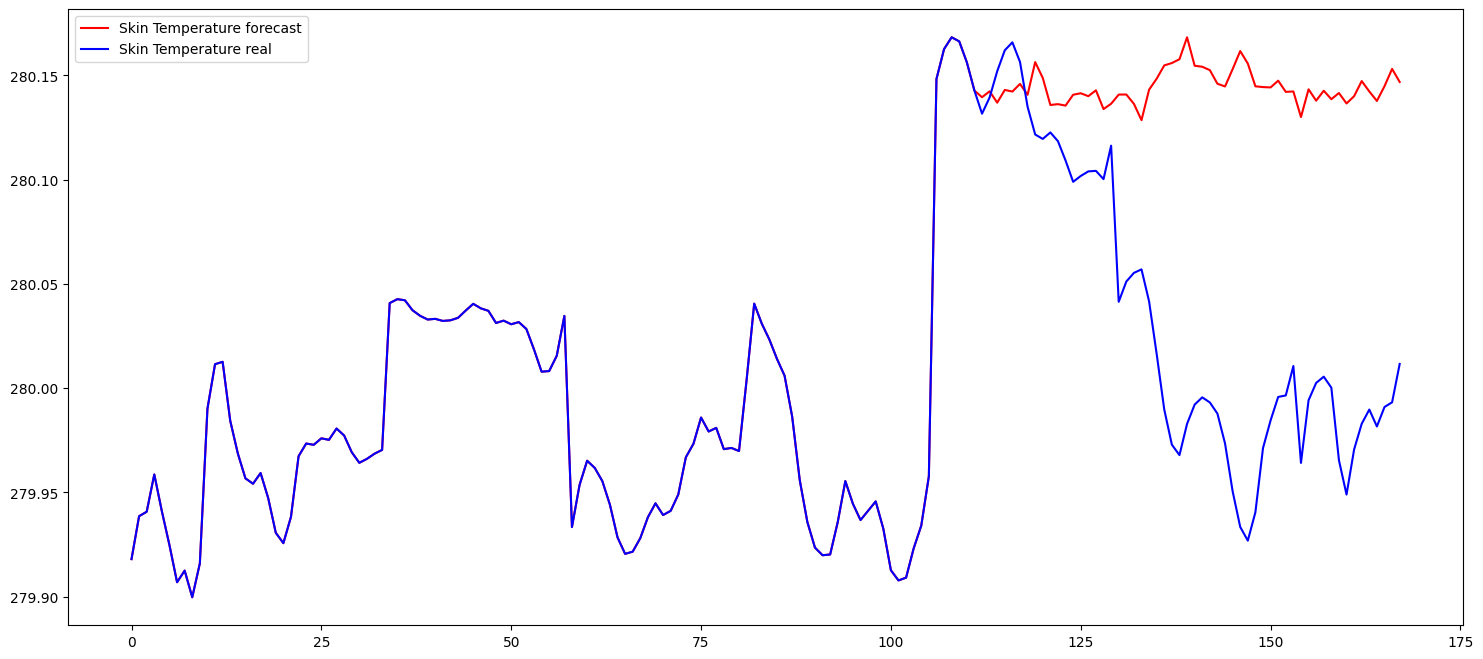

In [ ]:
var = 'skt'
lat, lon = (53.5, 4.0)
time_window = df_cluster['window'].unique()[3]

# Forecast the power spectral density using MESA on avg_power for a coordinate and window
sel_idx = df_cluster['window'] == time_window
sel_idx &= df_cluster['lat'] == lat
sel_idx &= df_cluster['lon'] == lon
arr_win = df_cluster.loc[sel_idx, var].values

n_fc = len(arr_win) // 3

mesa = MESA()
mesa.solve(arr_win[:-n_fc])

forecast_psd = mesa.forecast(arr_win[:-n_fc], length=n_fc, number_of_simulations=100)
median_forecast_win = np.median(forecast_psd, axis=0)

# Inverse FFT to time domain
reconstructed_signal = median_forecast_win

# reconstructed_signal is the forecast of the time series for the next half window
print("Reconstructed time domain forecast shape:", reconstructed_signal.shape)

plt.figure(figsize=(18, 8))
plt.plot(np.concat([
    arr_win[:-n_fc],
    reconstructed_signal
]), color='r', label=f'{variables[var]} forecast')
plt.plot(arr_win, color='b', label=f'{variables[var]} real')
plt.legend()